# Resources and references
And the data are gethared from *https://investing.com*

# Data Info
In our data, the column names were not given but the order is CLOSE, OPEN, HIGH, LOW and CHANGE

Data type: EUR/USD daily data.

the dates between 01/01/2000 and 28/02/2019 were used for train, validation.

test data would be march april or even other future dates.

**important: data should be reversed after read with pandas. The dataset from the investing.com is reversed. This effects prediction.**

# Task Info

Binary classification.
Classifies if the given time will have a higher value or lower value.

Later: Regression
Tries to predict exact price.

# Purpose

purpose of this exercise is to find out if using daily data is a good idea or not.

# Imports and Mount Google Drive

In [0]:
from __future__ import print_function, absolute_import, division

# general imports for deep learning
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# data read
import pandas as pd

# plot
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# json and pretty print
import json
import pprint

# to persist the numpy arrays data
import h5py

# handle logging
tf.logging.set_verbosity(tf.logging.INFO)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# check if correct place
!ls '/content/gdrive/My Drive/deep_learning/_data/forex/daily_csv/'

 EUR_USD_1980_1990.csv	 EUR_USD_2019_jan_feb.csv
 EUR_USD_1991_2000.csv	'EUR_USD Historical Data.csv'
 EUR_USD_2001_2018.csv	'EUR_USD Historical Data.gsheet'


# Data

Create the data list(even for one file)

In [0]:
# initialize file names
data_folder = "/content/gdrive/My Drive/deep_learning/_data/forex/daily_csv/"
data_filenames = []
data_filenames.append("EUR_USD Historical Data.csv")
#data_filenames.append("EURUSD_M1_2018.csv")

Read data list with pandas

In [0]:
# get train data that will be both validation and train data in training mode
data_1 = pd.read_csv(data_folder+data_filenames[0])

# Get all data as list
data_list = [data_1]

In [7]:
# print for understand the context
data_1.head()

,Date,Price,Open,High,Low,Change %
0,"Feb 28, 2019",1.1413,1.1379,1.1421,1.1368,0.29%
1,"Feb 27, 2019",1.1379,1.1389,1.1404,1.1362,-0.07%
2,"Feb 26, 2019",1.1387,1.1366,1.1404,1.1343,0.25%
3,"Feb 25, 2019",1.1359,1.1338,1.1369,1.1323,0.14%
4,"Feb 22, 2019",1.1343,1.1337,1.1360,1.1315,0.06%


## Functions for data preprocessing

In [0]:
# Tries to concatenate a list of arrays into one array
def get_concatenated_dataset(d_list):
  result_data = d_list[0]
  for d in d_list[1:]:
    result_data = np.concatenate((result_data, d), axis=None)
    
  return result_data

# Tries to check if the concatenated list is correct.
def concatenate_length_check(d_list, concatenated):
  print("----------- length check -----------")
  total_length = 0
  for d in d_list:  
    total_length += len(d)
    print("length: " +str(len(d)))

  print("concatenated length "+str(len(concatenated)))
  if(len(concatenated) == total_length):
    print("concatenated length -----------> CORRECT")
  else:
    print("concatenated length -----------> WRONG")

## Train Data
Get only train data that will be splitted into train and validation later.

And test data could be acquired in the future.

In [9]:
# Get OPEN, HIGH, LOW, CLOSE columns in all data
open_data_list=[]
high_data_list=[]
low_data_list=[]
close_data_list=[]

for d in data_list:
  open_data_list.append(d['Open'].as_matrix())
  high_data_list.append(d['High'].as_matrix())
  low_data_list.append(d['Low'].as_matrix())
  close_data_list.append(d['Price'].as_matrix())
  
# And CONCATENATE all of them
all_open_data = get_concatenated_dataset(open_data_list)
all_high_data = get_concatenated_dataset(high_data_list)
all_low_data = get_concatenated_dataset(low_data_list)
all_close_data = get_concatenated_dataset(close_data_list)
  
# CHECK IF CONCATENATION IS SUCCESSUL.
concatenate_length_check(open_data_list, all_open_data)
concatenate_length_check(high_data_list, all_high_data)
concatenate_length_check(low_data_list, all_low_data)
concatenate_length_check(close_data_list, all_close_data)

----------- length check -----------
length: 4999
concatenated length 4999
concatenated length -----------> CORRECT
----------- length check -----------
length: 4999
concatenated length 4999
concatenated length -----------> CORRECT
----------- length check -----------
length: 4999
concatenated length 4999
concatenated length -----------> CORRECT
----------- length check -----------
length: 4999
concatenated length 4999
concatenated length -----------> CORRECT


In [0]:
#TODO: get test data

# General Values

General properties for the model. Determines the actual data that will be processed.

In [0]:
# BATCH size of the lstm model
BATCH_SIZES = 100

# How many of the past points were involved.
WINDOWS = 100

# How many of data type is used as multivariate(open,high,low,close = 4)
EMB_SIZE = 4

# While training how many points should be ignored
STEP = 1

# Determines which time should be predictied
#(1 = 1 min further is predicted)
#(60 = 1 hour further is predicted)
FORECAST = 1

# Determines if the data is to be load.
LOAD = False

# Construct Data

## Functions

In [0]:
def get_data_chunks(d_list, length, window=30, forecast=1, step=1):
  X = []
  Y = []
  for i in range(0, length, step):
    try:
      # Get windowed data
      o = d_list[0][i:i+WINDOW] # open
      h = d_list[1][i:i+WINDOW] # high
      l = d_list[2][i:i+WINDOW] # low
      c = d_list[3][i:i+WINDOW] # close

      # Normalize data
      o = (np.array(o) - np.mean(o)) / np.std(o)
      h = (np.array(h) - np.mean(h)) / np.std(h)
      l = (np.array(l) - np.mean(l)) / np.std(l)
      c = (np.array(c) - np.mean(c)) / np.std(c)

      # x_i
      x_i = d_list[3][i:i+WINDOW]
      y_i = d_list[3][i+WINDOW+FORECAST]

      last_close = x_i[-1]
      next_close = y_i
      if last_close < next_close:
        y_i = [1, 0]
      else:
        y_i = [0, 1]

      x_i = np.column_stack((o,h,l,c))
    except Exception as e:
      print(e)
      # break when the limit is not enough
      break

    X.append(x_i)
    Y.append(y_i)
  print("data chunks are ready...")
  return [X, Y]

def get_train_validation(X, y, percentage=0.8):
    iXPercentage = int(len(X) * percentage) 
    iYPercentage = int(len(y) * percentage)
    X_train = X[0:iXPercentage]
    Y_train = y[0:iYPercentage]
    
    #X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_test = X[iXPercentage:]
    Y_test = y[iYPercentage:]

    return X_train, X_test, Y_train, Y_test

In [0]:
def save_data(x,y,x_test,y_test):
  # Save X, Y and X_test, Y_test
  save_folder = "/content/gdrive/My Drive/deep_learning/_data/numpy_arrays/"
  filename="daily_fx_multi_forecasting"

  # Save Y
  y_h5 = h5py.File(save_folder+filename+"_y.h5", 'w')
  y_h5.create_dataset('dataset_Y', data=y)
  y_h5.close()
  print("Saving Y Completed")

  # Save X
  x_h5 = h5py.File(save_folder+filename+"_x.h5", 'w')
  x_h5.create_dataset('dataset_X', data=x)
  x_h5.close()
  print("Saving X Completed")

  # Save X_test
  x_test_h5 = h5py.File(save_folder+filename+"_x_test.h5", 'w')
  x_test_h5.create_dataset('dataset_X_test', data=x_test)
  x_test_h5.close()
  print("Saving X_test Completed")

  # Save Y_test
  y_test_h5 = h5py.File(save_folder+filename+"_y_test.h5", 'w')
  y_test_h5.create_dataset('dataset_Y_test', data=y_test)
  y_test_h5.close()
  print("Saving Y_test Completed")


In [0]:
def get_data(should_loaded, d_list, d_list_test, train_len, test_len):
  if not should_loaded:
    # PROCESSES WHOLE TRAIN SET
    X, Y = get_data_chunks(d_list, train_len, window=WINDOW, forecast=FORECAST, step=STEP)
    X_test, Y_test = get_data_chunks(d_list_test, test_len, window=WINDOW, forecast=FORECAST, step=STEP)

    X = np.array(X)
    Y = np.array(Y)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
  else:
    save_folder = "/content/gdrive/My Drive/deep_learning/_data/numpy_arrays/"
    filename="daily_fx_multi_forecasting"
    
    h5f = h5py.File(save_folder+filename+"_x.h5",'r')
    X = h5f['dataset_X'][:]
    h5f.close()

    h5f = h5py.File(save_folder+filename+"_y.h5",'r')
    Y = h5f['dataset_Y'][:]
    h5f.close()

    h5f = h5py.File(save_folder+filename+"_x_test.h5",'r')
    X_test = h5f['dataset_X_test'][:]
    h5f.close()

    h5f = h5py.File(save_folder+filename+"_y_test.h5",'r')
    Y_test = h5f['dataset_Y_test'][:]
    h5f.close()
    pass
  
  return [X, Y, X_test, Y_test]



## Construction Process

In [0]:
save_folder = "/content/gdrive/My Drive/deep_learning/_data/numpy_arrays/"
filename = "daily_fx_multi_forecasting"

In [0]:
# REVERSE THE DATA BEFORE CONTINUE
print("all_open_data before flip: ---- >" + str(all_open_data))
all_open_data = np.flip(all_open_data, 0)
print("all_open_data after flip ---- >" + str(all_open_data))

all_high_data = np.flip(all_high_data, 0)
all_low_data = np.flip(all_low_data, 0)
all_close_data = np.flip(all_close_data, 0)

print("OPEN HIGH LOW CLOSE data were flipped successfully.")


all_open_data before flip: ---- >[1.1379 1.1389 1.1366 ... 1.0295 1.0244 1.0052]
all_open_data after flip ---- >[1.0052 1.0244 1.0295 ... 1.1366 1.1389 1.1379]
OPEN HIGH LOW CLOSE data were flipped successfully.


In [0]:
if not LOAD:
  d_list = [all_open_data, all_high_data, all_low_data, all_close_data]
# d_list_test = [test_open_data, test_high_data, test_low_data, test_close_data]

  # TODO: add actual d_list_test
  X, Y, X_test, Y_test = get_data(should_loaded=LOAD, 
                                d_list=d_list, 
                                d_list_test=d_list, 
                                train_len=len(all_close_data), 
                                test_len=len(all_close_data))
else:
    X, Y, X_test, Y_test = get_data(should_loaded=LOAD, 
                                d_list=None, 
                                d_list_test=None, 
                                train_len=0, 
                                test_len=0)
if not LOAD:
  save_data(X, Y, X_test, Y_test)


Observe some properties:

In [0]:
X_train, X_val, Y_train, Y_val = get_train_validation(X, Y)
print("OLD_shapes")
print(X.shape)
print(Y.shape)
print("*"*40)
print("New Shapes")
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

OLD_shapes
(4898, 100, 4)
(4898, 2)
****************************************
New Shapes
(3918, 100, 4)
(3918, 2)
(980, 100, 4)
(980, 2)


In [0]:
X_train[0]

In [0]:
# reshape data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], EMB_SIZE))
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3918, 100, 4)
(980, 100, 4)
(4898, 100, 4)


# SMOOTH
LSTMS require smoothed size.

In [0]:
def get_smooth_size(old_size, batch_size=BATCH_SIZE):
  new_size = old_size - old_size%batch_size
  print("Smoothed from: ["+str(old_size)+"] to: ["+str(new_size)+"]")
  return new_size

In [0]:
# MAKE THE DATA SMOOT FOR LSTM MODEL
train_smooth_size = get_smooth_size(X_train.shape[0])
test_smooth_size = get_smooth_size(X_test.shape[0])
val_smooth_size = get_smooth_size(X_val.shape[0])

X_train = X_train[:train_smooth_size] 
X_test = X_test[:test_smooth_size] 
X_val = X_val[:val_smooth_size] 

Y_train = Y_train[:train_smooth_size] 
Y_test = Y_test[:test_smooth_size] 
Y_val = Y_val[:val_smooth_size] 

Smoothed from: [3918] to: [3900]
Smoothed from: [4898] to: [4800]
Smoothed from: [980] to: [900]


# MODEL

## Model Function

In [0]:
def build_lstm_model(tensor_shape, batch_size=100, hidden_neurons=100):
  model = tf.keras.Sequential()
  model.add(layers.LSTM(hidden_neurons, 
                        batch_input_shape=(batch_size, tensor_shape[0], tensor_shape[1]), 
                        return_sequences=True))
  
  model.add(layers.LSTM(hidden_neurons, return_sequences=True))
  model.add(layers.LSTM(hidden_neurons))
  # TODO: check if flatten is needed or not.
  model.add(layers.Flatten())
  model.add(layers.Dense(64,activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(32,activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))
  return model
  

In [0]:
def build_lstm_model_1(tensor_shape, batch_size=100, hidden_neurons=100):
  model = tf.keras.Sequential()
# hyperbolic tangent is automatically seleceted as activation function
  model.add(layers.LSTM(hidden_neurons, batch_input_shape=(batch_size, tensor_shape[0], tensor_shape[1])))

# TODO
# model.add(layers.AveragePooling1D)
  model.add(layers.Dense(100,activation='relu'))
  model.add(layers.Dense(50,activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))
  return model

In [0]:
def build_lstm_model_3(tensor_shape, batch_size=100, hidden_neurons=100):
  model = tf.keras.Sequential()
# hyperbolic tangent is automatically seleceted as activation function
  model.add(layers.LSTM(hidden_neurons, batch_input_shape=(batch_size, tensor_shape[0], tensor_shape[1])))

# TODO
# model.add(layers.AveragePooling1D)
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Dense(2, activation='softmax'))
  return model

In [0]:
# IMPORTANT= THIS IS A FUNCTIONAL MODEL NOT A SEQUENTIAL.
def build_conv1d_model_4(tensor_shape, filters=64, kernel_size=3, pooling_size=2, dropout=0.5):
  #TODO: maybe add strides
  
  # initialize the placeholdder
  placeholder_input = tf.keras.Input(shape=tensor_shape)
  
  #------------- FIRST CNN BLOCK: CONV1D & MAXPOOLING ------------- 
  model = layers.Conv1D(filters=filters, 
                        kernel_size=kernel_size, 
                        padding="same",
                        input_shape=tensor_shape,
                        batch_input_shape=(None, tensor_shape[0], tensor_shape[1]),
                        activation='relu')(placeholder_input)
  
  model = layers.MaxPool1D(pool_size=pooling_size, padding="same")(model)
  
  # CONSIDER:  model = layers.BatchNormalization(model)  
  # ------------- Second CNN BLOCK: CONV1D & MAXPOOLING ------------- 
  model = layers.Conv1D(filters=filters, 
                        kernel_size=kernel_size, 
                        padding="same", 
                        activation='relu')(model)
  
  model = layers.MaxPool1D(pool_size=pooling_size, 
                           padding="same")(model)
  # ------------- DROPOUT & FLATTEN ------------- 
  model = layers.Dropout(dropout)(model)
  model = layers.Flatten()(model)
  
  
  model = layers.Dense(32, activation='relu')(model)
  model = layers.Dropout(dropout)(model)
  # not sure if this necessary 1
  #model = layers.Activation(activation='relu')(model)
  
  prediction = layers.Dense(2, activation='softmax')(model)
  
  model = tf.keras.Model(inputs=placeholder_input, outputs=prediction)
  return model
  # not sure if this necessary 1
#  model = layers.Activation(activation='sigmoid')(model)

In [0]:
# IMPORTANT= THIS IS A FUNCTIONAL MODEL NOT A SEQUENTIAL.
def build_conv1d_model_5(tensor_shape, filters=64, kernel_size=3, pooling_size=2, dropout=0.5):
  #TODO: maybe add strides
  
  # initialize the placeholdder
  placeholder_input = tf.keras.Input(shape=tensor_shape)
  
  #------------- FIRST CNN BLOCK: CONV1D & MAXPOOLING ------------- 
  model = layers.Conv1D(filters=filters, 
                        kernel_size=kernel_size, 
                        padding="same",
                        input_shape=tensor_shape,
                        batch_input_shape=(None, tensor_shape[0], tensor_shape[1]),
                        activation='relu')(placeholder_input)
  
  model = layers.AvgPool1D(pool_size=pooling_size, 
                           padding="same")(model)
  
  # CONSIDER:  model = layers.BatchNormalization(model)  
  # ------------- Second CNN BLOCK: CONV1D & MAXPOOLING ------------- 
  model = layers.Conv1D(filters=filters, 
                        kernel_size=kernel_size, 
                        padding="same", 
                        activation='relu')(model)
  
  model = layers.AvgPool1D(pool_size=pooling_size, 
                           padding="same")(model)
  # ------------- DROPOUT & FLATTEN ------------- 
  model = layers.Dropout(dropout)(model)
  model = layers.Flatten()(model)
  
  
  model = layers.Dense(32, activation='relu')(model)
  model = layers.Dropout(dropout)(model)
  # not sure if this necessary 1
  #model = layers.Activation(activation='relu')(model)
  
  prediction = layers.Dense(2, activation='softmax')(model)
  
  model = tf.keras.Model(inputs=placeholder_input, outputs=prediction)
  return model
  # not sure if this necessary 1
#  model = layers.Activation(activation='sigmoid')(model)

In [0]:
#TODO: weight initialization and L2 regularization
# A linear layer with L2 regularization of factor 0.02


def build_lstm_model_6(tensor_shape, batch_size=100, hidden_neurons=100, pooling_size=2):
  # L2 norm regularizer
  regularizer = tf.keras.regularizers.l2(0.01)
  
  # XAVIER INITIALIZER
  initializer = tf.keras.initializers.glorot_uniform()
  
  model = tf.keras.Sequential()
  
# hyperbolic tangent is automatically seleceted as activation function
  model.add(layers.LSTM(hidden_neurons, 
                        batch_input_shape=(batch_size, tensor_shape[0], tensor_shape[1]),
                        recurrent_regularizer=regularizer,
                        bias_regularizer=regularizer, 
                        kernel_regularizer=regularizer,
                        recurrent_initializer=initializer,
                        kernel_initializer=initializer,
                        bias_initializer=initializer
                       ))

# TODO

  #model.add(layers.AvgPool1D(pool_size = pooling_size, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(32, activation='relu', 
                         kernel_regularizer=regularizer, 
                         bias_regularizer=regularizer,
                         kernel_initializer=initializer,
                         bias_initializer=initializer))
  
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Dense(2, activation='softmax'))
  return model

In [0]:
#TODO: CNN + LSTMs and max pooling in cnn part, avarage pooling in lstm part.
def build_hybrid_model_7():
  pass

## Build Model

### Build Conv Model

In [0]:
# placeholder
#inputs = tf.keras.Input(shape=(32,32),dtype=np.float32)
model_4 = build_conv1d_model_4(tensor_shape=(X_train.shape[1], X_train.shape[2]))
model_5 = build_conv1d_model_5(tensor_shape=(X_train.shape[1], X_train.shape[2]))
# print the summary of the model
model_4.summary()
model_5.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 4)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 64)           832       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 64)            0         
_________________________________________________________________
dropout (Dropout)    

In [0]:
#OPTIMIZER
opt = 'adam'
#opt = tf.keras.optimizers.RMSprop()

loss_func = tf.keras.losses.categorical_crossentropy
metric =  tf.keras.metrics.categorical_accuracy

#tf.train.AdamOptimizer(learning_rate=0.002)

# CALLBACKS
save_folder = "/content/gdrive/My Drive/deep_learning/_data/numpy_arrays/"
fp = save_folder+"daily_fx_multi_model_lstm.hdf5"
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=fp, verbose=1, save_best_only=True)

#COMPILE
model_4.compile(optimizer=opt, 
              loss=loss_func,
              metrics=[metric])

model_5.compile(optimizer=opt, 
              loss=loss_func,
              metrics=[metric])


### Build LSTM Models

3rd Model.

In [0]:
print(X_train.shape)
#model = build_lstm_model(tensor_shape=(X_train.shape[1], X_train.shape[2]), batch_size=BATCH_SIZE)
model = build_lstm_model_1(tensor_shape=(X_train.shape[1], X_train.shape[2]), batch_size=BATCH_SIZE)
model_3 = build_lstm_model_3(tensor_shape=(X_train.shape[1], X_train.shape[2]), batch_size=BATCH_SIZE)
model.summary()
print("-----"*10)
model_3.summary()

(3900, 100, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (100, 100)                42000     
_________________________________________________________________
dense_9 (Dense)              (100, 100)                10100     
_________________________________________________________________
dense_10 (Dense)             (100, 50)                 5050      
_________________________________________________________________
dense_11 (Dense)             (100, 2)                  102       
Total params: 57,252
Trainable params: 57,252
Non-trainable params: 0
_________________________________________________________________
--------------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (100, 100)                42000     
______

In [0]:
model_6 = build_lstm_model_6(tensor_shape=(X_train.shape[1], X_train.shape[2]), batch_size=BATCH_SIZE)
model_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (100, 100)                42000     
_________________________________________________________________
batch_normalization_v1_2 (Ba (100, 100)                400       
_________________________________________________________________
dense_16 (Dense)             (100, 32)                 3232      
_________________________________________________________________
dropout_7 (Dropout)          (100, 32)                 0         
_________________________________________________________________
dense_17 (Dense)             (100, 2)                  66        
Total params: 45,698
Trainable params: 45,498
Non-trainable params: 200
_________________________________________________________________


In [0]:
#OPTIMIZER
opt = tf.keras.optimizers.Adam(lr=0.002)
#opt = tf.keras.optimizers.RMSprop()

loss_func = tf.keras.losses.categorical_crossentropy
metric =  tf.keras.metrics.categorical_accuracy

#tf.train.AdamOptimizer(learning_rate=0.002)

# CALLBACKS
save_folder = "/content/gdrive/My Drive/deep_learning/_data/numpy_arrays/"
fp = save_folder+"daily_fx_multi_model_lstm.hdf5"
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=fp, verbose=1, save_best_only=True)

#COMPILE
model.compile(optimizer=opt, loss=loss_func, metrics=[metric])
#COMPILE
model_3.compile(optimizer=opt, loss=loss_func, metrics=[metric])

#COMPILE
model_6.compile(optimizer=opt, loss=loss_func, metrics=[metric])


## TRAIN

### Train CONV1D Models


4th MODEL

In [0]:
# TRAIN
# epochs= 100 normally
# batch_size = 128
history_4 = model_4.fit(
            X_train, 
            Y_train, 
            epochs = 500,
            batch_size = BATCH_SIZE, 
            verbose=1, 
            validation_data=(X_val, Y_val),
            callbacks=[reduce_lr, checkpointer])


Train on 3900 samples, validate on 900 samples
Epoch 1/500
3700/3900 [===========================>..] - ETA: 0s - loss: 0.7078 - categorical_accuracy: 0.5092
Epoch 00001: val_loss improved from inf to 0.69432, saving model to /content/gdrive/My Drive/deep_learning/_data/numpy_arrays/daily_fx_multi_model_lstm.hdf5
3900/3900 [==============================] - 4s 1ms/sample - loss: 0.7077 - categorical_accuracy: 0.5067 - val_loss: 0.6943 - val_categorical_accuracy: 0.4967
Epoch 2/500
3700/3900 [===========================>..] - ETA: 0s - loss: 0.6930 - categorical_accuracy: 0.5143
Epoch 00002: val_loss did not improve from 0.69432
3900/3900 [==============================] - 0s 96us/sample - loss: 0.6927 - categorical_accuracy: 0.5167 - val_loss: 0.6969 - val_categorical_accuracy: 0.4789
Epoch 3/500
3700/3900 [===========================>..] - ETA: 0s - loss: 0.6939 - categorical_accuracy: 0.5149
Epoch 00003: val_loss improved from 0.69432 to 0.69422, saving model to /content/gdrive/My Dr

5th Model: with avarage pool

In [0]:
# TRAIN
# epochs= 100 normally
# batch_size = 128
history_5 = model_5.fit(
            X_train, 
            Y_train, 
            epochs = 200,
            batch_size = BATCH_SIZE, 
            verbose=1, 
            validation_data=(X_val, Y_val),
            callbacks=[reduce_lr, checkpointer])


Train on 3918 samples, validate on 980 samples
Epoch 1/200
3600/3918 [==========================>...] - ETA: 0s - loss: 0.6890 - categorical_accuracy: 0.5283
Epoch 00001: val_loss improved from 0.69326 to 0.69269, saving model to /content/gdrive/My Drive/deep_learning/_data/numpy_arrays/daily_fx_multi_model_lstm.hdf5
3918/3918 [==============================] - 1s 163us/sample - loss: 0.6895 - categorical_accuracy: 0.5227 - val_loss: 0.6927 - val_categorical_accuracy: 0.5071
Epoch 2/200
3600/3918 [==========================>...] - ETA: 0s - loss: 0.6878 - categorical_accuracy: 0.5422
Epoch 00002: val_loss did not improve from 0.69269
3918/3918 [==============================] - 0s 87us/sample - loss: 0.6877 - categorical_accuracy: 0.5434 - val_loss: 0.6927 - val_categorical_accuracy: 0.5143
Epoch 3/200
3600/3918 [==========================>...] - ETA: 0s - loss: 0.6866 - categorical_accuracy: 0.5364
Epoch 00003: val_loss did not improve from 0.69269
3918/3918 [=========================

### Train LSTM models

1st Model

In [0]:
# TRAIN
# epochs= 100 normally
# batch_size = 128
history_1 = model.fit(
            X_train, 
            Y_train, 
            epochs = 200,
            batch_size = BATCH_SIZE, 
            verbose=1, 
            validation_data=(X_val, Y_val),
            callbacks=[reduce_lr, checkpointer],
            shuffle=True)


Train on 3900 samples, validate on 900 samples
Epoch 1/200
3800/3900 [============================>.] - ETA: 0s - loss: 0.6954 - categorical_accuracy: 0.5008
Epoch 00001: val_loss improved from inf to 0.69579, saving model to /content/gdrive/My Drive/deep_learning/_data/numpy_arrays/daily_fx_multi_model_lstm.hdf5
3900/3900 [==============================] - 12s 3ms/sample - loss: 0.6953 - categorical_accuracy: 0.5015 - val_loss: 0.6958 - val_categorical_accuracy: 0.4856
Epoch 2/200
3800/3900 [============================>.] - ETA: 0s - loss: 0.6948 - categorical_accuracy: 0.5034
Epoch 00002: val_loss improved from 0.69579 to 0.69509, saving model to /content/gdrive/My Drive/deep_learning/_data/numpy_arrays/daily_fx_multi_model_lstm.hdf5
3900/3900 [==============================] - 9s 2ms/sample - loss: 0.6946 - categorical_accuracy: 0.5056 - val_loss: 0.6951 - val_categorical_accuracy: 0.4856
Epoch 3/200
3800/3900 [============================>.] - ETA: 0s - loss: 0.6923 - categorical_

3rd Model

In [0]:
# Try this 
# with: 500 epoch and 'adam' as optimizer.
history_3 = model_3.fit(
            X_train, 
            Y_train, 
            epochs = 1000,
            batch_size = BATCH_SIZE, 
            verbose=1, 
            validation_data=(X_val, Y_val),
            callbacks=[reduce_lr, checkpointer],
            shuffle=True)

3800/3900 [============================>.] - ETA: 0s - loss: 0.6922 - categorical_accuracy: 0.5218
Epoch 00862: val_loss did not improve from 0.69288
3900/3900 [==============================] - 9s 2ms/sample - loss: 0.6921 - categorical_accuracy: 0.5221 - val_loss: 0.6945 - val_categorical_accuracy: 0.5100
Epoch 863/1000
3800/3900 [============================>.] - ETA: 0s - loss: 0.6925 - categorical_accuracy: 0.5382
Epoch 00863: val_loss did not improve from 0.69288
3900/3900 [==============================] - 9s 2ms/sample - loss: 0.6926 - categorical_accuracy: 0.5364 - val_loss: 0.6945 - val_categorical_accuracy: 0.5089
Epoch 864/1000
3800/3900 [============================>.] - ETA: 0s - loss: 0.6903 - categorical_accuracy: 0.5332
Epoch 00864: val_loss did not improve from 0.69288
3900/3900 [==============================] - 9s 2ms/sample - loss: 0.6903 - categorical_accuracy: 0.5338 - val_loss: 0.6945 - val_categorical_accuracy: 0.5100
Epoch 865/1000
3800/3900 [=================

6th model: weight initializer and regularizers

In [0]:
# Try this 
# with: 500 epoch and 'adam' as optimizer.
history_6 = model_6.fit(
            X_train, 
            Y_train, 
            epochs = 300,
            batch_size = BATCH_SIZE, 
            verbose=1, 
            validation_data=(X_val, Y_val),
            callbacks=[reduce_lr, checkpointer],
            shuffle=True)

Train on 3900 samples, validate on 900 samples
Epoch 1/300
3800/3900 [============================>.] - ETA: 0s - loss: 2.1337 - categorical_accuracy: 0.4989
Epoch 00001: val_loss improved from 2.36551 to 1.90578, saving model to /content/gdrive/My Drive/deep_learning/_data/numpy_arrays/daily_fx_multi_model_lstm.hdf5
3900/3900 [==============================] - 9s 2ms/sample - loss: 2.1282 - categorical_accuracy: 0.4997 - val_loss: 1.9058 - val_categorical_accuracy: 0.5000
Epoch 2/300
3800/3900 [============================>.] - ETA: 0s - loss: 1.7840 - categorical_accuracy: 0.4982
Epoch 00002: val_loss improved from 1.90578 to 1.64752, saving model to /content/gdrive/My Drive/deep_learning/_data/numpy_arrays/daily_fx_multi_model_lstm.hdf5
3900/3900 [==============================] - 9s 2ms/sample - loss: 1.7801 - categorical_accuracy: 0.5013 - val_loss: 1.6475 - val_categorical_accuracy: 0.5122
Epoch 3/300
3800/3900 [============================>.] - ETA: 0s - loss: 1.5605 - categoric

## PLOT TRAINED MODELS

### PLOT CONV1D MODELS

PLOT 4th Model

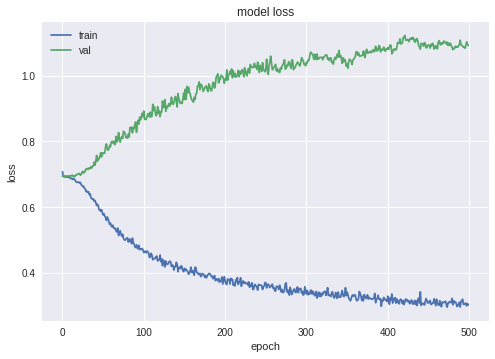

<Figure size 576x396 with 0 Axes>

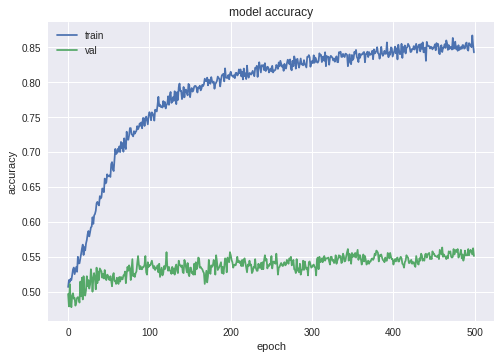

<Figure size 576x396 with 0 Axes>

In [0]:
# PLOT
plt.figure()
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

fp = save_folder + 'model_4:loss:e:500:opt:adam.png'
plt.savefig(fp)

plt.figure()
plt.plot(history_4.history['categorical_accuracy'])
plt.plot(history_4.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

fp = save_folder + 'model_4:acc:e:500:opt:adam.png'
plt.savefig(fp)

#
# RESULT: BAD PLOTS --- overfitting 

Plot 5th Model

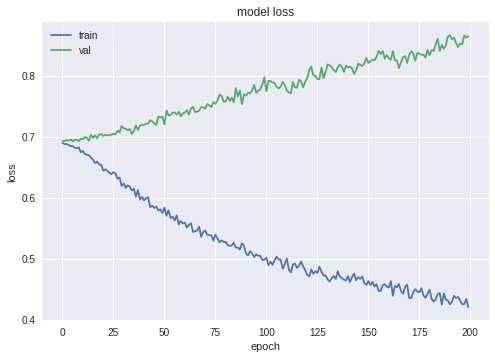

<Figure size 576x396 with 0 Axes>

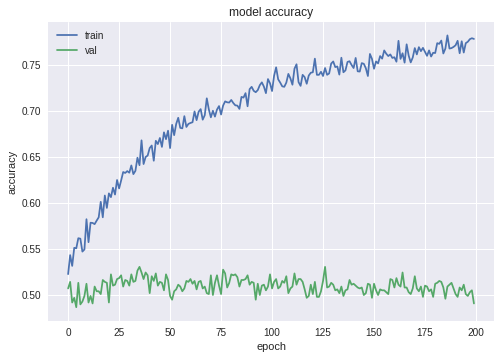

<Figure size 576x396 with 0 Axes>

In [0]:
# PLOT
plt.figure()
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

fp = save_folder + 'model_5:loss:e:500:opt:adam.png'
plt.savefig(fp)

plt.figure()
plt.plot(history_5.history['categorical_accuracy'])
plt.plot(history_5.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

fp = save_folder + 'model_5:acc:e:500:opt:adam.png'
plt.savefig(fp)

#
# RESULT: BAD PLOTS --- overfitting 

### PLOT LSTM MODELS

PLOT 1st model

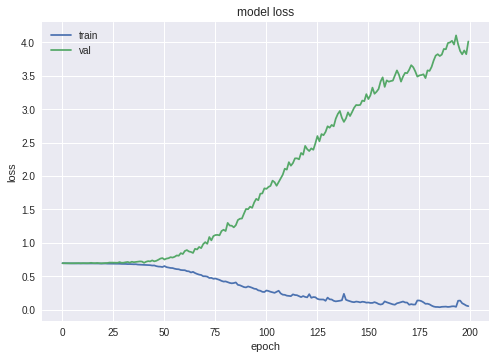

<Figure size 576x396 with 0 Axes>

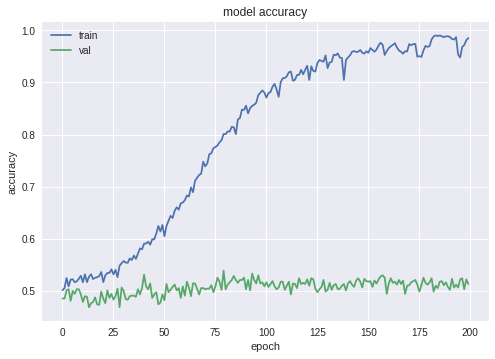

<Figure size 576x396 with 0 Axes>

In [0]:
# PLOT
plt.figure()
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

fp = save_folder + 'model_1:loss:e:200:opt:rmsprop.png'
plt.savefig(fp)

plt.figure()
plt.plot(history_1.history['categorical_accuracy'])
plt.plot(history_1.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

fp = save_folder + 'model_1:acc:e:200:opt:rmsprop.png'
plt.savefig(fp)

#
# RESULT: BAD PLOTS --- overfitting 

plot 3rd model

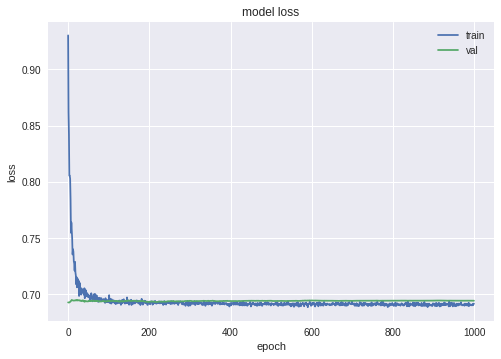

<Figure size 576x396 with 0 Axes>

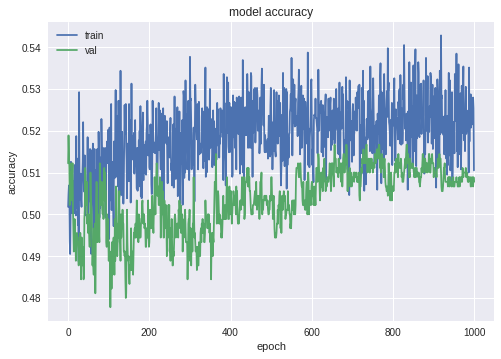

<Figure size 576x396 with 0 Axes>

In [0]:
# PLOT
plt.figure()
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

fp = save_folder + 'model_3:loss:e:1000:opt:rmsprop.png'
plt.savefig(fp)

plt.figure()
plt.plot(history_3.history['categorical_accuracy'])
plt.plot(history_3.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

fp = save_folder + 'model_3:acc:e:1000:opt:rmsprop.png'
plt.savefig(fp)

#RESULT: BAD PLOTS --- underfitting(perhaps too much dropout)

plot 6th model

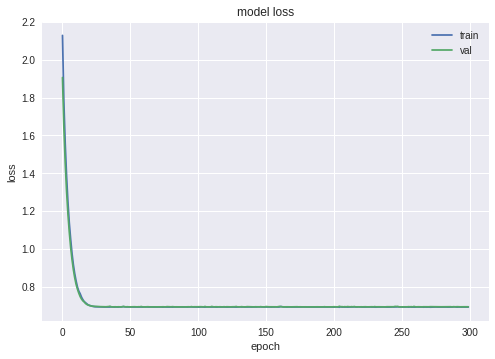

<Figure size 576x396 with 0 Axes>

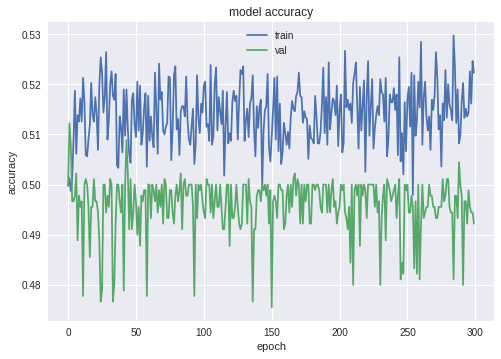

<Figure size 576x396 with 0 Axes>

In [0]:
# PLOT
plt.figure()
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

fp = save_folder + 'model_6:loss:e:300:opt:adam.png'
plt.savefig(fp)

plt.figure()
plt.plot(history_6.history['categorical_accuracy'])
plt.plot(history_6.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

fp = save_folder + 'model_6:acc:e:300:opt:adam.png'
plt.savefig(fp)

#RESULT: BAD PLOTS --- underfitting(perhaps too much dropout)

# PREDICT AND PLOT

TODO: add the results of conv1d model

In [0]:
# load data
fp = save_folder + "daily_fx_multi_model_lstm.hdf5"

model_loaded = build_lstm_model_3(tensor_shape=(X_train.shape[1], X_train.shape[2]), batch_size=BATCH_SIZE)
model_loaded = model_loaded.load_weights(fp)

# and use an already fully trained model.
model_fully_trained = model_3

## VALIDATION DATA

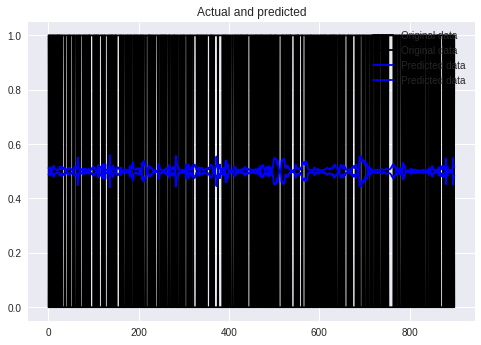

In [0]:
# plot the prediction of the trained model 
pred = model_fully_trained.predict(np.array(X_val))

#PLOT
original = Y_val 
predicted = pred
plt.plot(original, 
         color='black', 
         label = 'Original data') 
plt.plot(predicted, 
         color='blue', 
         label = 'Predicted data') 

plt.legend(loc='best') 
plt.title('Actual and predicted') 
plt.show()



## TRAIN DATA

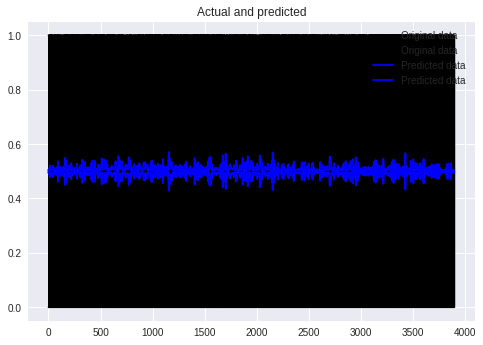

In [0]:
# plot the prediction of the trained model 
pred = model_fully_trained.predict(np.array(X_train))

#PLOT
original = Y_train
predicted = pred
plt.plot(original, 
         color='black', 
         label = 'Original data') 
plt.plot(predicted, 
         color='blue', 
         label = 'Predicted data') 

plt.legend(loc='best') 
plt.title('Actual and predicted') 
plt.show()

## TEST DATA

Gets 2019's March data and tests the model on it.

In [0]:
# get march data

In [0]:
# evaluate
model_fully_trained.evaluate(X_test,Y_test,batch_size=BATCH_SIZE)

4800/4800 [==============================] - 5s 959us/sample - loss: 0.6910 - categorical_accuracy: 0.5210


[0.6909812030692896, 0.5210417]